In [11]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import datetime
from pytz import timezone
est = timezone('US/Eastern')


In [ ]:
from twilio.rest import Client

# Your Account SID from twilio.com/console
account_sid = "*******"
# Your Auth Token from twilio.com/console
auth_token  = "*******"

client = Client(account_sid, auth_token)



# data = pd.read_csv("merged_data.csv")

# datag = data[['Price','Sentiment']].groupby(data['Time']).mean()

In [3]:
data = pd.read_csv("merged2.csv")

# datag = data[['Price','Sentiment']].groupby(data['Time']).mean()

In [4]:
data.head()

,Time,polarity,sensitivity,Tweet_vol,Open,High,Low,Price,Volume (BTC),Volume (Currency),Weighted Price
0,11-07-2018 20:00,0.102657,0.216148,4354,6342.97,6354.19,6291.00,6350.00,986.73,6231532.37,6315.33
1,11-07-2018 21:00,0.098004,0.218612,4432,6352.99,6370.00,6345.76,6356.48,126.46,804221.55,6359.53
2,11-07-2018 22:00,0.096688,0.231342,3980,6350.85,6378.47,6345.00,6361.93,259.10,1646353.87,6354.12
3,11-07-2018 23:00,0.103997,0.217739,3830,6362.36,6381.25,6356.74,6368.78,81.54,519278.69,6368.23
4,12-07-2018 00:00,0.094383,0.195256,3998,6369.49,6381.25,6361.83,6380.00,124.55,793560.22,6371.51


In [6]:
datag = data[['Price','polarity']].groupby(data['Time']).mean()

In [7]:
datag.head()

,Price,polarity
Time,,
11-07-2018 20:00,6350.00,0.102657
11-07-2018 21:00,6356.48,0.098004
11-07-2018 22:00,6361.93,0.096688
11-07-2018 23:00,6368.78,0.103997
12-07-2018 00:00,6380.00,0.094383


In [1]:
import pandas as pd
datag = pd.read_csv('final_dataset.csv')

In [2]:
datag.head()

,Unnamed: 0,time_x,low,high,open,close,volume,pol,RSI,SMA
0,5,2021-01-06,33352.54,37000.00,34043.91,36859.26,45744.103200,39.697416,72.68,39091.79
1,6,2021-01-07,36200.00,40425.00,36859.26,39505.56,50346.305691,42.358659,42.20,38810.46
2,7,2021-01-08,36565.08,41986.37,39510.55,40665.15,48522.484903,16.940548,14.89,37717.14
3,8,2021-01-09,38800.00,41406.94,40642.15,40257.43,27152.971029,12.754143,33.61,37062.85
4,9,2021-01-10,34444.00,41452.12,40257.43,38171.57,43736.570316,8.077794,44.99,36836.39


In [5]:
datagg = datag.drop(['RSI','SMA'],axis=1)
datagg.head()

,Unnamed: 0,time_x,low,high,open,close,volume,pol
0,5,2021-01-06,33352.54,37000.00,34043.91,36859.26,45744.103200,39.697416
1,6,2021-01-07,36200.00,40425.00,36859.26,39505.56,50346.305691,42.358659
2,7,2021-01-08,36565.08,41986.37,39510.55,40665.15,48522.484903,16.940548
3,8,2021-01-09,38800.00,41406.94,40642.15,40257.43,27152.971029,12.754143
4,9,2021-01-10,34444.00,41452.12,40257.43,38171.57,43736.570316,8.077794


In [6]:
from sklearn.preprocessing import MinMaxScaler
values = datag['close'].values.reshape(-1,1)
sentiment = datag['pol'].values.reshape(-1,1)
values = values.astype('float32')
sentiment = sentiment.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
split = train_size

251 109


In [7]:
def create_dataset(dataset, look_back, sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):
                a.append(sentiment[i].tolist()[0])
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    #print(len(dataY))
    return np.array(dataX), np.array(dataY)


In [12]:
# import numpy as np
look_back = 2
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size],sent=True)
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)], sent=True)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

yhat = model.predict(testX)

yhat_inverse_sent = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse_sent = scaler.inverse_transform(testY.reshape(-1, 1))

rmse_sent = sqrt(mean_squared_error(testY_inverse_sent, yhat_inverse_sent))
print('Test RMSE: %.3f' % rmse_sent)


Test RMSE: 3095.100


In [13]:
yhat

array([[0.46216998],
       [0.4388533 ],
       [0.45039716],
       [0.4737936 ],
       [0.39507848],
       [0.30273417],
       [0.35045153],
       [0.37422416],
       [0.39330223],
       [0.3565111 ],
       [0.32497862],
       [0.3182111 ],
       [0.2907535 ],
       [0.28031906],
       [0.3324679 ],
       [0.43591216],
       [0.49398872],
       [0.46080616],
       [0.5205277 ],
       [0.5270384 ],
       [0.652498  ],
       [0.6677535 ],
       [0.63014394],
       [0.62303114],
       [0.6643782 ],
       [0.69041264],
       [0.6953971 ],
       [0.66829246],
       [0.6922715 ],
       [0.7698257 ],
       [0.82894903],
       [0.8231835 ],
       [0.78089094],
       [0.85064   ],
       [0.9112362 ],
       [0.8915854 ],
       [0.83223337],
       [0.76866823],
       [0.78228724],
       [0.8565093 ],
       [0.8398712 ],
       [0.758008  ],
       [0.7669882 ],
       [0.84155184],
       [0.8275407 ],
       [0.7787026 ],
       [0.7685047 ],
       [0.826

In [ ]:
import MySQLdb
#Enter the values for you database connection
dsn_database = "bitcoin"         # e.g. "MySQLdbtest"
dsn_hostname = "173.194.231.244"      # e.g.: "mydbinstance.xyz.us-east-1.rds.amazonaws.com"
dsn_port = 3306                  # e.g. 3306 
dsn_uid = "demo"             # e.g. "user1"
dsn_pwd = "qwerty@123"              # e.g. "Password123"

conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)

cursor=conn.cursor()


import queue 
import time

import queue
import matplotlib.pyplot as plt
true_q = queue.Queue()
pred_q = queue.Queue()
'''
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()
plt.ion()
'''

def process_data(in_data):
    out_data = []
    for line in in_data:
        out_data.append(float(line.split(',')[0]))
    return np.array(out_data).reshape(-1,1)
prev = 15000
threshold = 0.05
while True:
    btc = open('live_bitcoin.csv','r')
    sent = open('live_tweet.csv','r')
    bit_data = btc.readlines()
    sent_data = sent.readlines()
    bit_data = process_data(bit_data[len(bit_data)-5:])
    sent_data = process_data(sent_data[len(sent_data)-5:])
    live = scaler.transform(bit_data)
    testX, testY = create_dataset(live, 2, sent_data, sent=True)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    yhat = model.predict(testX)
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    true_q.put(bit_data[4])
    pred_q.put(yhat_inverse[0])
    val = 100*((yhat_inverse[0][0] - prev)/prev)
    if val > threshold:
        decision = 'Buy!!!'
        message = client.messages.create(to="+15184234418‬", from_="+15188883052", body=decision+' - Price of Bitcoin is expected to rise.')
    elif val <-threshold:
        decision = 'Sell!!!'
        message = client.messages.create(to="+15184234418", from_="+15188883052", body=decision+' - Price of Bitcoin is expected to drop.')
    else:
        decision = ''
    prev = yhat_inverse[0][0]
    input_string = "INSERT INTO live_data values ({},{},{},'{}','{}');".format(yhat_inverse[0][0],bit_data[0][0],sent_data[4][0],datetime.datetime.now(tz=est).strftime('%Y-%m-%d %H:%M:%S'),decision)
    cursor.execute(input_string)
    conn.commit()
    time.sleep(60)

In [12]:
pip install Historic-Crypto

Note: you may need to restart the kernel to use updated packages.


# Following youtube

In [1]:
import pandas as pd
datag = pd.read_csv('final_dataset.csv')

In [2]:
datag.head()

,Unnamed: 0,time_x,low,high,open,close,volume,pol
0,5,06-01-2021,33352.54,37000.00,34043.91,36859.26,45744.10320,39.697416
1,6,07-01-2021,36200.00,40425.00,36859.26,39505.56,50346.30569,42.358659
2,7,08-01-2021,36565.08,41986.37,39510.55,40665.15,48522.48490,16.940548
3,8,09-01-2021,38800.00,41406.94,40642.15,40257.43,27152.97103,12.754143
4,9,10-01-2021,34444.00,41452.12,40257.43,38171.57,43736.57032,8.077794


In [3]:
# datagg = datag.drop(['RSI','SMA'],axis=1)
# datagg.head()

In [16]:
datagg = datag[['low','high','open','close','volume','pol']]
datagg

,low,high,open,close,volume,pol
0,33352.54,37000.00,34043.91,36859.26,45744.10320,39.697416
1,36200.00,40425.00,36859.26,39505.56,50346.30569,42.358659
2,36565.08,41986.37,39510.55,40665.15,48522.48490,16.940548
3,38800.00,41406.94,40642.15,40257.43,27152.97103,12.754143
4,34444.00,41452.12,40257.43,38171.57,43736.57032,8.077794
...,...,...,...,...,...,...
355,50480.00,52100.00,50804.33,50717.77,11596.91468,18.403056
356,47300.23,50720.35,50720.35,47543.09,23116.75584,19.171833
357,46094.02,48149.58,47542.20,46471.24,20326.32142,16.132080
358,45938.44,47926.15,46471.24,47122.08,27413.65365,11.595228


In [5]:
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
# import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [101]:
#pip install plotly

In [6]:
prediction_days = 60

# Set Train data to be uplo ( Total data length - prediction_days )
df_train= datagg[:len(datagg)-prediction_days].values #.reshape(-1,1)


# Set Test data to be the last prediction_days (or 60 days in this case)
df_test= datagg[len(datagg)-prediction_days:].values#.reshape(-1,1)

In [7]:
# datagg[:len(datagg)-prediction_days].values
df_train.shape
# x = df_test.reshape(-1,1)

(300, 6)

In [8]:
# x.reshape((60,6))
# testing = [[1,2,3],[4,5,6],[7,8,9]]
# tt = pd.DataFrame(testing)
# testing.values

In [9]:
# tt.values.reshape(-1,1)

In [10]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train.reshape(-1,1))
scaled_train = scaled_train.reshape((300,6))

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test.reshape(-1,1))
scaled_test = scaled_test.reshape((60,6))

In [11]:
scaled_train

array([[3.04510094e-01, 3.37807745e-01, 3.10821608e-01, 3.36522930e-01,
        4.17632635e-01, 3.97259150e-04],
       [3.30504547e-01, 3.69074559e-01, 3.36522930e-01, 3.60680994e-01,
        4.59646127e-01, 4.21553634e-04],
       [3.33837361e-01, 3.83328300e-01, 3.60726548e-01, 3.71266887e-01,
        4.42996473e-01, 1.89511775e-04],
       ...,
       [5.54393286e-01, 5.69494381e-01, 5.68661360e-01, 5.65050477e-01,
        6.20535870e-02, 1.71038958e-04],
       [5.47783801e-01, 5.69930930e-01, 5.65086719e-01, 5.60041122e-01,
        7.64552450e-02, 7.74910460e-05],
       [5.43210173e-01, 5.70597164e-01, 5.60063853e-01, 5.56443019e-01,
        1.07066339e-01, 1.07497001e-04]])

In [12]:
#X values in dataset Generator
scaled_train[0:7,0] 

array([0.30451009, 0.33050455, 0.33383736, 0.35423994, 0.31447403,
       0.27481767, 0.29672726])

In [13]:
#Y value in dataset generator
scaled_train[7,3]

0.3414014654105549

In [14]:
import numpy as np
def dataset_generator_lstm(dataset, look_back):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back)]#, 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 3]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train,7)

testX, testY = dataset_generator_lstm(scaled_test,7)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (293, 7, 6)
trainY:  (293,)
testX:  (53, 7, 6)
testY (53,)


In [15]:
trainX[0]

array([[3.04510094e-01, 3.37807745e-01, 3.10821608e-01, 3.36522930e-01,
        4.17632635e-01, 3.97259150e-04],
       [3.30504547e-01, 3.69074559e-01, 3.36522930e-01, 3.60680994e-01,
        4.59646127e-01, 4.21553634e-04],
       [3.33837361e-01, 3.83328300e-01, 3.60726548e-01, 3.71266887e-01,
        4.42996473e-01, 1.89511775e-04],
       [3.54239939e-01, 3.78038686e-01, 3.71056920e-01, 3.67544813e-01,
        2.47914248e-01, 1.51294099e-04],
       [3.14474029e-01, 3.78451134e-01, 3.67544813e-01, 3.48503003e-01,
        3.99305874e-01, 1.08603718e-04],
       [2.74817666e-01, 3.49436991e-01, 3.48478538e-01, 3.23681444e-01,
        9.35785855e-01, 1.07703813e-04],
       [2.96727259e-01, 3.34197318e-01, 3.23720698e-01, 3.10776602e-01,
        4.40304721e-01, 3.82462838e-04]])

## Reshaping as a 3D
- not needed now as the trainX,testX are itself 3D

In [75]:
# trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

# testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (293, 7, 6)
Shape of testX:  (53, 7, 6)


In [76]:
print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  7
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  6


In [77]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

# Note - If I plan to add 3-rd or 4-th layers of LSTM then 
# I must set return_sequences=True in the 2-nd layer above
# so that the 3-rd LSTM layer has a compatible n-dimensional sequence input.

# Adding a third LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 128)            69120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 118,595
Trainable params: 118,595
Non-trainable params: 0
________________________________________________

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]
# callbacks = [checkpoint]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/600
 9/10 [==========================>...] - ETA: 0s - loss: 0.0553
Epoch 00001: val_loss improved from inf to 0.03154, saving model to my_best_model.hdf5
10/10 [==============================] - 2s 158ms/step - loss: 0.0545 - val_loss: 0.0315
Epoch 2/600
 9/10 [==========================>...] - ETA: 0s - loss: 0.0103
Epoch 00002: val_loss did not improve from 0.03154
10/10 [==============================] - 0s 26ms/step - loss: 0.0104 - val_loss: 0.0485
Epoch 3/600
 8/10 [=======================>......] - ETA: 0s - loss: 0.0065
Epoch 00003: val_loss improved from 0.03154 to 0.00517, saving model to my_best_model.hdf5
10/10 [==============================] - 0s 29ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 4/600
 8/10 [=======================>......] - ETA: 0s - loss: 0.0053
Epoch 00004: val_loss did not improve from 0.00517
10/10 [==============================] - 0s 19ms/step - loss: 0.0052 - val_loss: 0.0069
Epoch 5/600
 7/10 [====================>.........] - ETA: 0s - 

In [79]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

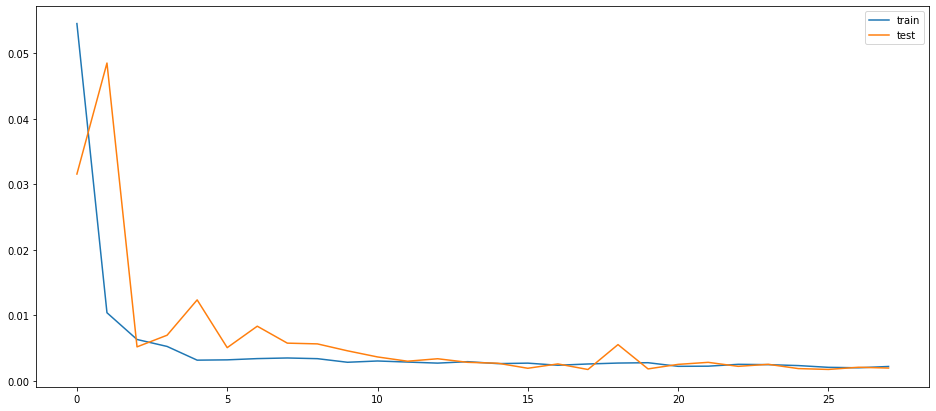

In [80]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## LSTM Predictions using testX and plotting line graph against Actual testY

In [81]:
len(testX)

53

In [82]:
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)


In [38]:
# len(predicted_btc_price_test_data)
# testY.reshape(-1,1)
# predicted_btc_price_test_data.reshape(-1 ,6)

In [83]:
testY

array([0.97021118, 0.94075396, 0.93923781, 0.92967667, 0.9333306 ,
       0.94934593, 0.92209214, 0.87112457, 0.87465415, 0.82460111,
       0.84234333, 0.86609218, 0.85030092, 0.81565595, 0.83429501,
       0.82843693, 0.8548817 , 0.77908712, 0.7936005 , 0.8306763 ,
       0.83822576, 0.82590508, 0.82936219, 0.81914378, 0.77735328,
       0.71362704, 0.71715038, 0.73230089, 0.7336911 , 0.7321577 ,
       0.68938411, 0.68362314, 0.71604207, 0.72592497, 0.67720185,
       0.70096432, 0.70846247, 0.69033763, 0.66906541, 0.67910874,
       0.67661196, 0.68007414, 0.70889611, 0.70445998, 0.7368321 ,
       0.73696515, 0.73083344, 0.73624643, 0.73502869, 0.68901685,
       0.67348212, 0.68291499, 0.66971384])

In [114]:
# predicted_btc_price_test_data_original = predicted_btc_price_test_data
# testY

array([4.39175168e-03, 8.70574116e-01, 9.21277177e-01, 9.16902206e-01,
       9.12103592e-01, 1.87673178e-01, 2.67937783e-04, 4.40624506e-03,
       8.80121920e-01, 9.14693994e-01, 9.12103447e-01, 8.90495267e-01,
       1.60134114e-01, 1.73318354e-04, 4.42073844e-03, 8.80820936e-01,
       9.07801667e-01, 8.90495122e-01, 8.84142094e-01, 1.53569159e-01,
       1.82876990e-04, 4.43523182e-03, 8.71371252e-01, 8.92738118e-01,
       8.84141949e-01, 8.91869384e-01, 9.22279914e-02, 1.10316814e-04,
       4.44972520e-03, 8.89819296e-01, 9.17792969e-01, 8.91869240e-01,
       9.17520058e-01, 8.10620887e-02, 1.84140861e-04, 4.46421858e-03,
       9.17519913e-01, 9.82503157e-01, 9.17519913e-01, 9.79054747e-01,
       2.55937015e-01, 1.69525151e-04, 4.47871196e-03, 9.60314082e-01,
       9.93751179e-01, 9.79044457e-01, 9.70211176e-01, 2.17308564e-01,
       3.75261777e-04, 4.49320534e-03, 9.10141044e-01, 1.00000000e+00,
       9.70125665e-01, 9.40753961e-01, 2.75769353e-01, 2.32434821e-04,
      

In [84]:
# scaler_test2 = MinMaxScaler(feature_range=(0, 1))
# ValueError: non-broadcastable output operand with shape (53,1) doesn't match the broadcast shape (53,6)
#here inverser_transorm prev applied on (53,6) and hence doesn't works for predicted price of shape(53,1)
#created a array of shape (53,6) with zeros and replace first pos with pred_price array

# nn = np.zeros((53,6))
# nn[:,0]= predicted_btc_price_test_data[:,0]
# nn.reshape(-1,1)
# predicted_btc_price_test_data = scaler_test.inverse_transform(nn)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

In [85]:
predicted_btc_price_test_data

array([[59538.63 ],
       [60076.074],
       [60555.57 ],
       [61053.87 ],
       [61432.31 ],
       [61779.336],
       [62007.562],
       [62062.1  ],
       [61351.88 ],
       [60586.   ],
       [59400.688],
       [58226.945],
       [57167.418],
       [56341.16 ],
       [55510.605],
       [55251.906],
       [55065.03 ],
       [55253.48 ],
       [55025.83 ],
       [54420.207],
       [53875.145],
       [53848.227],
       [53854.418],
       [53828.543],
       [53690.883],
       [53790.05 ],
       [52785.17 ],
       [51462.277],
       [49951.582],
       [48874.254],
       [47962.12 ],
       [47068.96 ],
       [46429.785],
       [46850.277],
       [47046.1  ],
       [46995.566],
       [46525.98 ],
       [46081.25 ],
       [45989.91 ],
       [45848.562],
       [45639.2  ],
       [45314.4  ],
       [45289.13 ],
       [45302.62 ],
       [45526.87 ],
       [45647.848],
       [46278.105],
       [46912.926],
       [47525.363],
       [48238.785],


In [49]:
# test_actual = testY

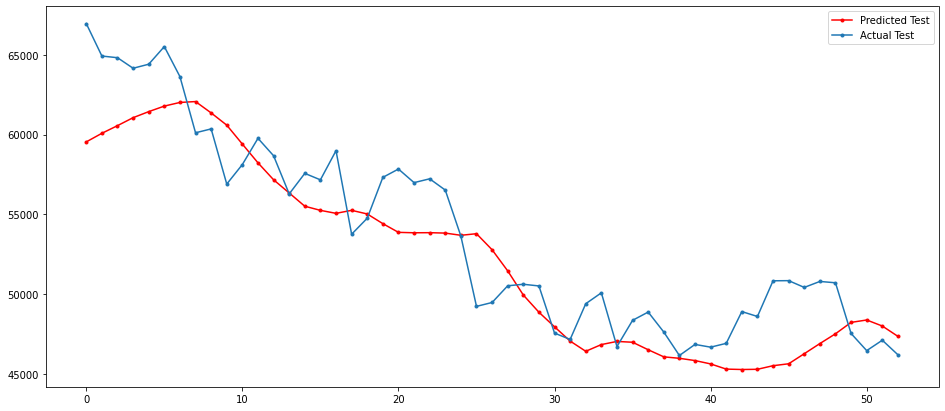

In [86]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

## LSTM Prediction using trainX and plotting line graph against Actual trainY

In [87]:
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))
# train_actual = trainY

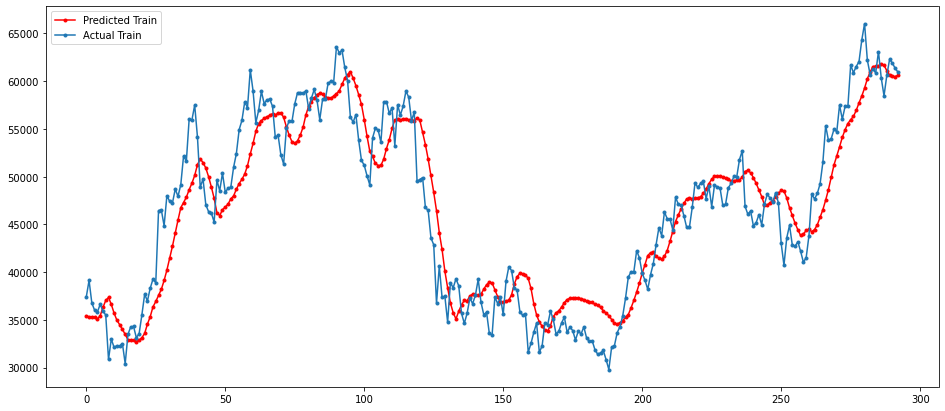

In [88]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

## RMSE - Test Data

In [89]:
import math
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)
#prev rmse=8788.126

Test RMSE: 2855.296


## RMSE - Train Data

In [90]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)
#prev is 6079.801

Test RMSE: 3489.402


## Predicting beyond existing data

In [91]:
testX
testX.shape

(53, 7, 6)

In [92]:
lookback_period = 7

# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast for Future 5 days beyond 30-Oct-2021

testX_last_7_days = testX[testX.shape[0] - lookback_period :  ]

testX_last_7_days.shape

(7, 7, 6)

In [93]:
testX_last_7_days

array([[[6.59633405e-01, 6.86489783e-01, 6.68969316e-01, 6.79108740e-01,
         1.18380056e-01, 9.74662976e-05],
        [6.73030941e-01, 7.00739530e-01, 6.79080188e-01, 6.76611965e-01,
         1.37915017e-01, 9.65014927e-05],
        [6.60391119e-01, 6.89101490e-01, 6.76612110e-01, 6.80074144e-01,
         2.32421681e-01, 9.32139694e-05],
        [6.76001214e-01, 7.15050148e-01, 6.80074144e-01, 7.08896114e-01,
         2.24044877e-01, 8.58056001e-05],
        [7.02161040e-01, 7.18755960e-01, 7.08896114e-01, 7.04459980e-01,
         1.55811326e-01, 2.25796885e-04],
        [6.96105126e-01, 7.44884916e-01, 7.04459835e-01, 7.36832104e-01,
         2.40938878e-01, 1.72790082e-04],
        [7.31083305e-01, 7.51853043e-01, 7.36830075e-01, 7.36965153e-01,
         1.69390973e-01, 3.51160564e-04]],

       [[6.73030941e-01, 7.00739530e-01, 6.79080188e-01, 6.76611965e-01,
         1.37915017e-01, 9.65014927e-05],
        [6.60391119e-01, 6.89101490e-01, 6.76612110e-01, 6.80074144e-01,
     

In [94]:
predicted_7_days_forecast_price_test_x = []

for i in range(7):
    
  predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_7_days[i:i+1])
  
  predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_7_days_forecast_price_test_x.append(predicted_forecast_price_test_x)
  
print("Forecast for the next 7 Days Beyond the actual trading days ", np.array(predicted_7_days_forecast_price_test_x)) 

Forecast for the next 7 Days Beyond the actual trading days  [[[46278.11 ]]

 [[46912.926]]

 [[47525.37 ]]

 [[48238.793]]

 [[48388.527]]

 [[48010.637]]

 [[47363.617]]]


In [95]:
predicted_7_days_forecast_price_test_x = np.array(predicted_7_days_forecast_price_test_x)

predicted_7_days_forecast_price_test_x.shape

(7, 1, 1)

In [96]:
predicted_btc_price_test_data.shape

(53, 1)

In [97]:
predicted_btc_price_test_data

array([[59538.63 ],
       [60076.074],
       [60555.57 ],
       [61053.87 ],
       [61432.31 ],
       [61779.336],
       [62007.562],
       [62062.1  ],
       [61351.88 ],
       [60586.   ],
       [59400.688],
       [58226.945],
       [57167.418],
       [56341.16 ],
       [55510.605],
       [55251.906],
       [55065.03 ],
       [55253.48 ],
       [55025.83 ],
       [54420.207],
       [53875.145],
       [53848.227],
       [53854.418],
       [53828.543],
       [53690.883],
       [53790.05 ],
       [52785.17 ],
       [51462.277],
       [49951.582],
       [48874.254],
       [47962.12 ],
       [47068.96 ],
       [46429.785],
       [46850.277],
       [47046.1  ],
       [46995.566],
       [46525.98 ],
       [46081.25 ],
       [45989.91 ],
       [45848.562],
       [45639.2  ],
       [45314.4  ],
       [45289.13 ],
       [45302.62 ],
       [45526.87 ],
       [45647.848],
       [46278.105],
       [46912.926],
       [47525.363],
       [48238.785],


In [98]:
predicted_7_days_forecast_price_test_x

array([[[46278.11 ]],

       [[46912.926]],

       [[47525.37 ]],

       [[48238.793]],

       [[48388.527]],

       [[48010.637]],

       [[47363.617]]], dtype=float32)

In [99]:
predicted_7_days_forecast_price_test_x = predicted_7_days_forecast_price_test_x.flatten()

predicted_7_days_forecast_price_test_x

array([46278.11 , 46912.926, 47525.37 , 48238.793, 48388.527, 48010.637,
       47363.617], dtype=float32)

In [100]:
predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()

predicted_btc_price_test_data

array([59538.63 , 60076.074, 60555.57 , 61053.87 , 61432.31 , 61779.336,
       62007.562, 62062.1  , 61351.88 , 60586.   , 59400.688, 58226.945,
       57167.418, 56341.16 , 55510.605, 55251.906, 55065.03 , 55253.48 ,
       55025.83 , 54420.207, 53875.145, 53848.227, 53854.418, 53828.543,
       53690.883, 53790.05 , 52785.17 , 51462.277, 49951.582, 48874.254,
       47962.12 , 47068.96 , 46429.785, 46850.277, 47046.1  , 46995.566,
       46525.98 , 46081.25 , 45989.91 , 45848.562, 45639.2  , 45314.4  ,
       45289.13 , 45302.62 , 45526.87 , 45647.848, 46278.105, 46912.926,
       47525.363, 48238.785, 48388.51 , 48010.633, 47363.62 ],
      dtype=float32)

In [101]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_7_days_forecast_price_test_x))

predicted_btc_test_concatenated

# predicted_btc_test_concatenated.shape

array([59538.63 , 60076.074, 60555.57 , 61053.87 , 61432.31 , 61779.336,
       62007.562, 62062.1  , 61351.88 , 60586.   , 59400.688, 58226.945,
       57167.418, 56341.16 , 55510.605, 55251.906, 55065.03 , 55253.48 ,
       55025.83 , 54420.207, 53875.145, 53848.227, 53854.418, 53828.543,
       53690.883, 53790.05 , 52785.17 , 51462.277, 49951.582, 48874.254,
       47962.12 , 47068.96 , 46429.785, 46850.277, 47046.1  , 46995.566,
       46525.98 , 46081.25 , 45989.91 , 45848.562, 45639.2  , 45314.4  ,
       45289.13 , 45302.62 , 45526.87 , 45647.848, 46278.105, 46912.926,
       47525.363, 48238.785, 48388.51 , 48010.633, 47363.62 , 46278.11 ,
       46912.926, 47525.37 , 48238.793, 48388.527, 48010.637, 47363.617],
      dtype=float32)

## Finally Plot entire Predictions of Test Data (including the Future 7-days ) against Actual testY

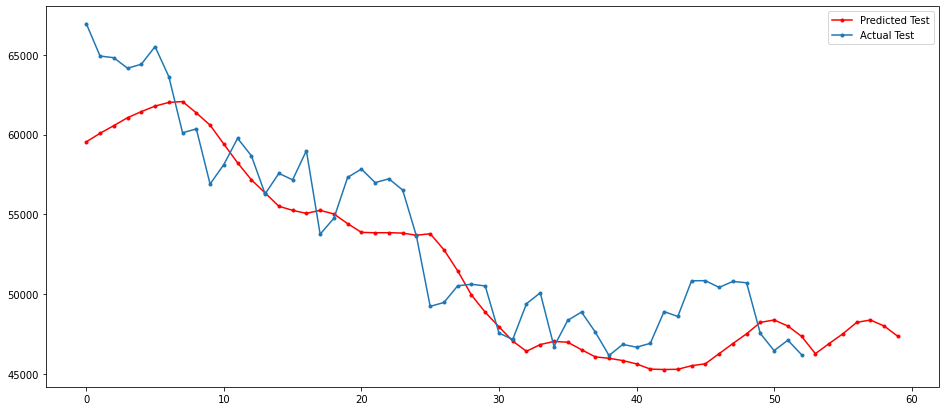

In [102]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()

plt.show()

In [ ]:
mse = sklearn.metrics.mean_squared_error(actual, predicted)

rmse = math.sqrt(mse)